In [1]:
import os
os.chdir("../pytorchObjectDetection")
import numpy as np
import pickle
import pycocotools
import torch
import torch.utils.data
from PIL import Image
from PIL import ImageDraw
import pandas as pd
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from engine import train_one_epoch, evaluate
import utils
import transforms as T
import torchvision
import xml.etree.ElementTree as ET
import glob
os.chdir('../src')

In [2]:
class WeaponDataset(torch.utils.data.Dataset):
    
    def __init__(self, dicPics,categories, path, transforms=None): 
        self.path = path
        self.dicPics = dicPics
        self.transforms = transforms
        self.categories = categories
        self.imgs = [o for o in dicPics]

    def __getitem__(self, idx):
        img = Image.open(self.path +"/"+ self.imgs[idx]).convert("RGB")        
        box_list = self.dicPics[self.imgs[idx]][0]
        target = {}
        if len(box_list) is not 0:
        
            boxes = torch.as_tensor(box_list, dtype=torch.float32)
            num_objs = len(box_list)
            labels_list =  self.dicPics[self.imgs[idx]][1]

            # multible classes
            labels = torch.zeros((num_objs,), dtype=torch.int64)

            for i in range(num_objs):
                labels[i] = self.categories[labels_list[i]]
            #print(labels)
            image_id = torch.tensor([idx])
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:,0])

            # suppose all instances are not crowd
            iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
            target["boxes"] = boxes
            target["labels"] = labels
            target["image_id"] = image_id
            target["area"] = area
            target["iscrowd"] = iscrowd
        
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        
        return img, target
    
    def __len__(self):
        return len(self.imgs)

In [3]:
def load_dic(path):
    if os.path.isfile(path):
        return pickle.load( open( path, "rb" ) )
    else:
        print("no such file")
        return 0

In [4]:
pathDataset = "../BaggagesData/dictionariesData"
pathTrainDictionary = pathDataset + "/TestDicData.pkl"
imgbbox_test = load_dic(pathTrainDictionary)
imgbbox_test_nw = load_dic("../BaggagesData/dictionariesData/test_nowp.pkl") # baggabe with no weapons
imgbbox_test.update(imgbbox_test_nw)
len(imgbbox_test)


76

In [5]:
def get_model(num_classes):
  # load an object detection model pre-trained on COCO
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
  # get the number of input features for the classifier
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  # replace the pre-trained head with a new on
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features,num_classes)
   
  return model

In [6]:
def get_transform(train):
    transforms = []
   # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
      # during training, randomly flip the training images
      # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [7]:
# To load trained model
cat = {'handgun': 1,'knife': 2, 'razorblade': 3, 'shuriken': 4}

model_name = '../Trained_models/model_1465images_5Classes_5epochs_finished'
loaded_model = get_model(num_classes = len(cat) +1 )

if os.path.isfile(model_name):
    loaded_model.load_state_dict(torch.load(model_name, map_location=torch.device('cpu') ))
    loaded_model.eval()
else:
    print("Wrong path or filename")

In [8]:

pathDataset_test_imgs = "../BaggagesData/Test"
# use our dataset and defined transformations
dataset_test = WeaponDataset(dicPics = imgbbox_test, categories = cat, path = pathDataset_test_imgs, transforms = get_transform(train=False))   # Testing

print("Test set: {} examples".format(len(dataset_test)))

Test set: 76 examples


## Prediction on images

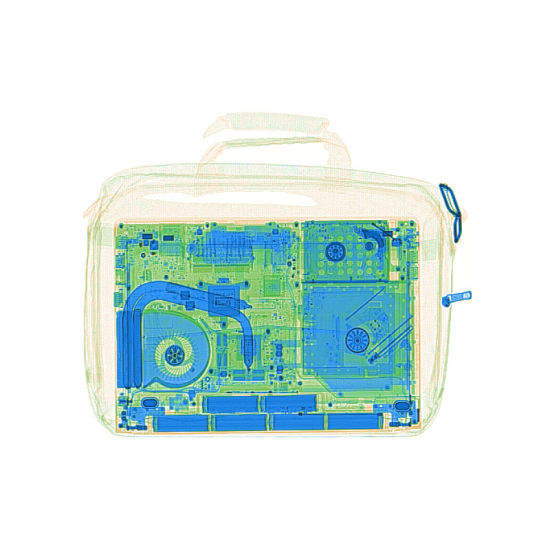

In [9]:

idx = 72
#for idx in range(1):

cat_color = {1:"red", 2:"yellow", 3: "blue", 4:"orange"}

img, _ = dataset_test[idx]

#label_boxes = np.array(dataset_test[idx][1]["boxes"])
#put the model in evaluation mode
with torch.no_grad():
    prediction = loaded_model([img])
    
image = Image.fromarray(img.mul(255).permute(1, 2,0).byte().numpy())
draw = ImageDraw.Draw(image)

cat_rev = {cat[o]: o for o in cat}

# draw groundtruth
#for elem in range(len(label_boxes)):
#    draw.rectangle([(label_boxes[elem][0], label_boxes[elem][1]),
#    (label_boxes[elem][2], label_boxes[elem][3])], 
#    outline ="green", width =3)
    
for element in range(len(prediction[0]["boxes"])):

    boxes = prediction[0]["boxes"][element].cpu().numpy()
    score = np.round(prediction[0]["scores"][element].cpu().numpy(),
                    decimals= 4)
    if score > 0.8:

        draw.rectangle([(boxes[0], boxes[1]), (boxes[2], boxes[3])], outline =cat_color[np.int(prediction[0]["labels"][element])], width =3)
        draw.text((boxes[0], boxes[1]), text = str(score)+ " " + cat_rev[np.int(prediction[0]["labels"][element])] , fill="#000")
display(image)


 # General baggage statistics

In [ ]:
labels = {cat[o]: o for o in cat}

TP, FP, FN, TN = 0, 0, 0, 0

for idx in range(len(dataset_test)):
    
    gt_labels = 0
    img, targets = dataset_test[idx]
    
    gt_labels = np.array([])
    with torch.no_grad():
        prediction = loaded_model([img])[0]
    
    if len(targets) is not 0:
        gt_labels = targets["labels"].numpy()
        
    pred_labels = prediction["labels"].numpy()[prediction["scores"].numpy() > 0.7]
    
    if  (gt_labels.any()  == True  and pred_labels.any() == True):
        TP += 1
    elif (gt_labels.any() == False and pred_labels.any() == True):
        FP += 1
    elif (gt_labels.any() == True  and pred_labels.any() == False):
        FN += 1
    elif (gt_labels.any() == False and pred_labels.any() == False):
        TN += 1
    

    print("{}:\tTP: {}, FP: {}, FN: {}, TN: {}  |  Accuracy: {:.4f},  Precition: {:.3f},  Recall: {:.3f}".format(
                                                       (idx+1),TP,FP,FN,TN,(1-((FP+FN)/(TP+TN))), TP/(TP+FP), TP/(TP+FN) )) 

# Object statistics

In [ ]:
#heihei her kommer litt statistikk om objektene våre